#### **Task 2**
 1. Perform "Action Recognition" on the KTH-Actions dataset:
    - https://www.csc.kth.se/cvap/actions/
    - https://github.com/tejaskhot/KTH-Dataset
    - Already downloaded in `/home/nfs/inf6/data/datasets/kth_actions`
    - Use spatial dimensionality of frames of 64x64
    - Split videos into subsequences of e.g. 10 frames. Treat each of these subsequences as independent.
    - Feel free to use augmentations (temporal and/or spatial)
    

<br>

2. Implement a model with the following structure:
    - Convolutional encoder (probably more powerful than the one from above)
    - Recurrent module
    - Classifier (probably Conv + AvgPooling/Flattening + Linear)


<br>

3. Train, evaluate, and compare the model with the recurrent modules listed below.<br>
   Compare the models in terms of accuracy, training/inference time, and number of learnable parameters.<br>
   **Log the experiments on Tensorboard/WandB**. <br>
   RNNs to evaluate:
    - PyTorch LSTM model (using nn.LSTMCell)
    - PyTorch GRU model (using nn.GRUCell)
    - Your own LSTM
    - Your own ConvLSTM
    - **Note**: Different recurrent modules (e.g. LSTM vs ConvLSTM) might require slight changes in the encoder and classifier

In [1]:
from utils import *
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import yaml
import torch
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import random
import re
import shutil
from pytorch_lightning import seed_everything
from transformations import get_train_transforms,get_test_transforms
from dataloader import KTHActionDataset
from torch.utils.tensorboard import SummaryWriter


/home/user/soltania1/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/user/soltania1/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-05-19 20:06:12.427915: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-19 20:06:13.045145: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
configs = {
    "model_name" : "OwnLSTM",
    "exp" : "",  # experiment label
    "emb_dim" : 128,
    "hidden_dim" : 128,
    "num_layers" : 4,
    "batch_size" : 32,
    "num_epochs" : 60,
    "lr" : 1e-3,
    "scheduler" : "StepLR",
    "use_scheduler" : False,
    "use_pretrained_encoder" : False,
    'max_frames' : 80,
    'slicing_step' : 8,
}

In [3]:

# Create datasets
root_dir = "/home/nfs/inf6/data/datasets/kth_actions/processed/"

train_dataset = KTHActionDataset(root_dir, 
                                 split="train", 
                                 transform=get_train_transforms(configs['slicing_step']), 
                                 max_frames=configs['max_frames'], 
                                 img_size=(64, 64))

test_dataset = KTHActionDataset(root_dir, 
                                split="test", 
                                transform=get_test_transforms(configs['slicing_step']), 
                                # transform=None,
                                max_frames=configs['max_frames'], 
                                img_size=(64, 64))


In [4]:
# train_dataset[2]

### Data Visualization

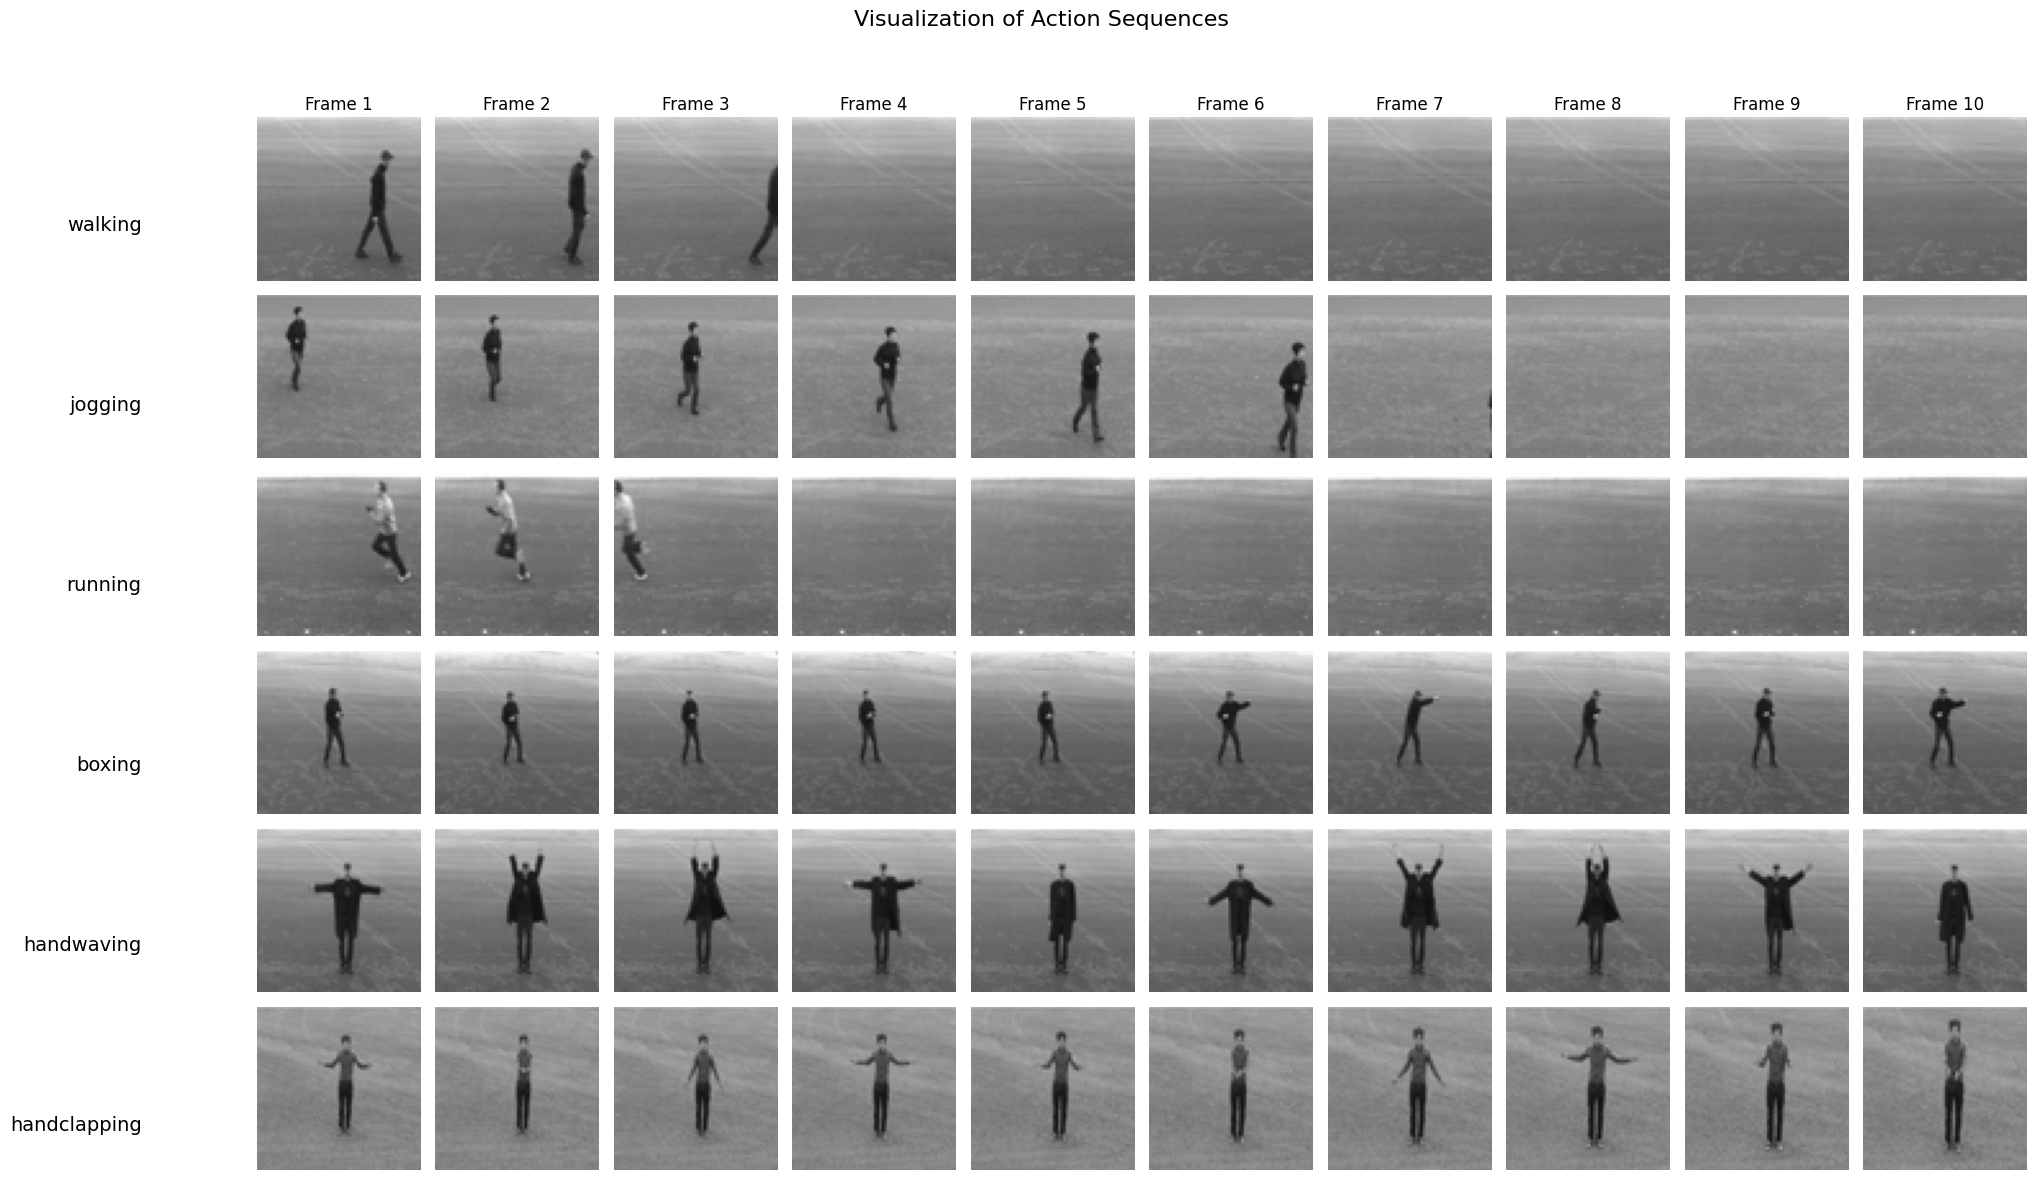

In [5]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

frames, labels = next(iter(test_loader))

unique_labels = np.unique(labels.numpy())
fig, axes = plt.subplots(len(unique_labels), 10, figsize=(20, 12))
fig.suptitle('Visualization of Action Sequences', fontsize=16)

if len(unique_labels) == 1:
    axes = np.expand_dims(axes, axis=0)

categories = ['walking', 'jogging', 'running', 'boxing', 'handwaving', 'handclapping']

# For each action category in this batch
for i, action_idx in enumerate(unique_labels):
    # Find all samples of this action in the batch
    action_samples = frames[labels == action_idx]
    if len(action_samples) > 0:
        sample = action_samples[0]
        
        for frame_idx in range(10):
            frame = sample[frame_idx].squeeze().cpu().numpy()
   
            axes[i, frame_idx].imshow(frame, cmap='gray', vmin=0, vmax=1)
            axes[i, frame_idx].axis('off')
            
            # Add frame number to the first row
            if i == 0:
                axes[i, frame_idx].set_title(f'Frame {frame_idx+1}')
    
    row_height = 0.9/len(unique_labels)
    row_center = 0.9 - (i * row_height + row_height/2)
    action_name = categories[action_idx.item()]
    
    # Move label down by adding a negative offset to y-coordinate
    vertical_offset = 0.025  # Approximate adjustment for 0.3cm
    fig.text(0.05, row_center - vertical_offset, 
             action_name, 
             fontsize=14, 
             ha='right',
             va='center')

plt.tight_layout(rect=[0.1, 0, 1, 0.95]) 
plt.show()

In [6]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, 
                          batch_size=configs['batch_size'], 
                          shuffle=True, 
                          num_workers=4)

test_loader = DataLoader(test_dataset, 
                         batch_size=configs['batch_size'], 
                         shuffle=False, 
                         num_workers=4)

In [7]:
## Verifying the dataloader  
for batch in test_loader:
    frames, labels = batch
    print(f"Batch shape: {frames.shape}, Labels: {labels.shape}")
    break

Batch shape: torch.Size([32, 10, 1, 64, 64]), Labels: torch.Size([32])


In [8]:

class OwnLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # Hyperparameters
        super(OwnLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Xavier weight initialization
        def init_weights(layer):
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight, gain=1.0)
                nn.init.zeros_(layer.bias)

        # Forget Gate
        self.forget_gate = nn.Linear(input_size + hidden_size, hidden_size)
        init_weights(self.forget_gate)

        # Input Gate
        self.input_gate = nn.Linear(input_size + hidden_size, hidden_size)
        init_weights(self.input_gate)

        # Candidate Gate
        self.candidate_gate = nn.Linear(input_size + hidden_size, hidden_size)
        init_weights(self.candidate_gate)

        # Output Gate
        self.output_gate = nn.Linear(input_size + hidden_size, hidden_size)
        init_weights(self.output_gate)

        # Final Layer
        self.final_layer = nn.Linear(hidden_size, output_size)
        init_weights(self.final_layer)

    def reset_hidden(self, batch_size, device):
        """Initialize hidden state and cell state to zeros"""
        return (torch.zeros(batch_size, self.hidden_size, device=device),
                torch.zeros(batch_size, self.hidden_size, device=device))

    def forward(self, x):
        """
        Forward pass through the LSTM
        Args:
            x: Input tensor of shape [batch_size, seq_len, input_size] or [batch_size, input_size]
        Returns:
            outputs: Final output or all outputs depending on input shape
        """
        # Handle different input shapes
        if len(x.size()) == 2:  # [batch_size, input_size]
            batch_size, _ = x.size()
            seq_len = 1
            x = x.unsqueeze(1)  # Convert to [batch_size, 1, input_size]
        elif len(x.size()) == 3:  # [batch_size, seq_len, input_size]
            batch_size, seq_len, _ = x.size()
        else:
            raise ValueError(f"Expected input with 2 or 3 dimensions, got {len(x.size())}")
            
        device = x.device
        
        # Initialize hidden state and cell state
        h_t, c_t = self.reset_hidden(batch_size, device)
        
        # Store all outputs for each timestep
        outputs = []
        
        for t in range(seq_len):
            x_t = x[:, t, :]
            
            # Concatenate input with previous hidden state
            combined = torch.cat((x_t, h_t), dim=1)
            
            # Apply gates
            f_t = torch.sigmoid(self.forget_gate(combined))
            i_t = torch.sigmoid(self.input_gate(combined))
            c_tilde = torch.tanh(self.candidate_gate(combined))
            o_t = torch.sigmoid(self.output_gate(combined))
            
            # Update cell state
            c_t = f_t * c_t + i_t * c_tilde
            
            # Update hidden state
            h_t = o_t * torch.tanh(c_t)
            
            # Compute output for current timestep
            output = self.final_layer(h_t)
            outputs.append(output)
        
        # If input was 2D, return just the final output
        if len(x.size()) == 3 and seq_len == 1:
            return outputs[0]  # Return [batch_size, output_size]
            
        # Otherwise stack all outputs
        outputs = torch.stack(outputs, dim=1)  # [batch_size, seq_len, output_size]
        
        return outputs


In [9]:
# ##### Long Short-Term Memory Network Class #####

# # Xavier Normalized Initialization
# def initWeights(input_size, output_size):
#     return np.random.uniform(-1, 1, (output_size, input_size)) * np.sqrt(6 / (input_size + output_size))


# ##### Activation Functions #####
# def sigmoid(input, derivative = False):
#     if derivative:
#         return input * (1 - input)
    
#     return 1 / (1 + np.exp(-input))

# def tanh(input, derivative = False):
#     if derivative:
#         return 1 - input ** 2
    
#     return np.tanh(input)

# def softmax(input):
#     return np.exp(input) / np.sum(np.exp(input))


# class OwnLSTM(nn.Module):
    # def __init__(self, input_size, hidden_size, output_size):
    #     # Hyperparameters
    #     super().__init__()
    #     self.hidden_size = hidden_size

    #     # Forget Gate
    #     self.wf = initWeights(input_size, hidden_size)
    #     self.bf = np.zeros((hidden_size, 1))

    #     # Input Gate
    #     self.wi = initWeights(input_size, hidden_size)
    #     self.bi = np.zeros((hidden_size, 1))

    #     # Candidate Gate
    #     self.wc = initWeights(input_size, hidden_size)
    #     self.bc = np.zeros((hidden_size, 1))

    #     # Output Gate
    #     self.wo = initWeights(input_size, hidden_size)
    #     self.bo = np.zeros((hidden_size, 1))

    #     # Final Gate
    #     self.wy = initWeights(hidden_size, output_size)
    #     self.by = np.zeros((output_size, 1))

    # # Reset Network Memory
    # def reset(self):
    #     self.concat_inputs = {}

    #     self.hidden_states = {-1:np.zeros((self.hidden_size, 1))}
    #     self.cell_states = {-1:np.zeros((self.hidden_size, 1))}

    #     self.activation_outputs = {}
    #     self.candidate_gates = {}
    #     self.output_gates = {}
    #     self.forget_gates = {}
    #     self.input_gates = {}
    #     self.outputs = {}

    # def forward(self, inputs):
    #     self.reset()

    #     outputs = []
    #     for q in range(len(inputs)):
    #         self.concat_inputs[q] = np.concatenate((self.hidden_states[q - 1], inputs[q]))

    #         self.forget_gates[q] = sigmoid(np.dot(self.wf, self.concat_inputs[q]) + self.bf)
    #         self.input_gates[q] = sigmoid(np.dot(self.wi, self.concat_inputs[q]) + self.bi)
    #         self.candidate_gates[q] = tanh(np.dot(self.wc, self.concat_inputs[q]) + self.bc)
    #         self.output_gates[q] = sigmoid(np.dot(self.wo, self.concat_inputs[q]) + self.bo)

    #         self.cell_states[q] = self.forget_gates[q] * self.cell_states[q - 1] + self.input_gates[q] * self.candidate_gates[q]
    #         self.hidden_states[q] = self.output_gates[q] * tanh(self.cell_states[q])

    #         outputs += [np.dot(self.wy, self.hidden_states[q]) + self.by]

    #     return outputs

In [10]:
def SelectRNN(emb_dim, hidden_dim, num_layers, network : str = 'LSTMCell') -> nn.Module:

    assert network in ("LSTMCell", "GRUCell", "OwnLSTM", "OwnConvLSTM"), f"Invalid network type: {network}"

    if network == "LSTMCell":
        lstms = []
        for i in range(num_layers):
            in_size = emb_dim if i == 0 else hidden_dim
            lstms.append( nn.LSTMCell(input_size=in_size, hidden_size=hidden_dim) )
        RNN = nn.ModuleList(lstms)
        
    elif network == "GRUCell":
        grus = []
        for i in range(num_layers):
            in_size = emb_dim if i == 0 else hidden_dim
            grus.append(nn.GRUCell(input_size=in_size, hidden_size=hidden_dim))
        RNN = nn.ModuleList(grus)
        
    elif network == "OwnLSTM":
        RNN = OwnLSTM(input_size=emb_dim, hidden_size=hidden_dim, output_size=hidden_dim)

    elif network == "OwnConvLSTM":
        pass
        
    return RNN

In [11]:
class ActionClassifier(nn.Module):

    def __init__(self, emb_dim, hidden_dim, rnn_network, num_layers=1, mode="zeros"):
        """ Module initializer """
        assert mode in ["zeros", "random"]
        super().__init__()
        self.hidden_dim =  hidden_dim
        self.num_layers = num_layers
        self.rnn_ = rnn_network
        # self.embed_dim = emb_dim
        self.mode = mode
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        
        if configs['use_pretrained_encoder'] == True:

            resnet = models.resnet18(pretrained=True)
            resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            
            self.encoder = nn.Sequential(
                *list(resnet.children())[:-1],  # Remove the final fc layer
                nn.Conv2d(512, emb_dim, kernel_size=1),  # Project to desired embedding dimension
                nn.AdaptiveAvgPool2d((1, 1))  # -->(batch_size, emb_dim, 1, 1)
            )
        else:
            self.encoder = nn.Sequential(                   # (batch_size, 1(n_channels), H, W)
                nn.Conv2d(1, 16, kernel_size=5),  nn.BatchNorm2d(16), nn.GELU(), nn.MaxPool2d(2),   
                nn.Conv2d(16, 32, kernel_size=3), nn.BatchNorm2d(32), nn.GELU(), nn.MaxPool2d(2),  
                nn.Conv2d(32, 64, kernel_size=3), nn.BatchNorm2d(64), nn.GELU(), nn.MaxPool2d(2),  
                nn.Conv2d(64, 128,kernel_size=3), nn.BatchNorm2d(128),  nn.GELU(), nn.MaxPool2d(2),
                nn.Conv2d(128, emb_dim, kernel_size=1),               
                nn.AdaptiveAvgPool2d((1, 1))    #Averages each channel to a single value.(batch_size, emb_dim, 1, 1)
            )
        
        # RNN model
        self.rnn = SelectRNN(emb_dim= emb_dim , 
                             hidden_dim=self.hidden_dim, 
                             network= self.rnn_, 
                             num_layers= self.num_layers).to(device)
        
        
        # Classifier (Conv + AvgPooling + Linear) as described in the assignment
        """
        Convolutions are effective at capturing local dependencies and reducing dimensionality,
        making the features more compact and focused for classification.
        """
        self.classifier = nn.Sequential(
            nn.Conv1d(in_channels=hidden_dim, out_channels=32, kernel_size=3, padding=1), # conv1d to capture local tempral dependencies
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),   # ---> classification, one output needed here
            nn.Flatten(),
            nn.Linear(32, 6)
        )
        
        return
    

    def forward(self, x):
        b_size, num_frames, n_channels, H, W = x.shape
        h_init, c_init = self.init_state(b_size=b_size, device=x.device)
        
        # encoding all images in parallel rows
        x = x.view(b_size * num_frames, n_channels, H, W)
        embeddings = self.encoder(x)  
        embeddings = embeddings.reshape(b_size, num_frames, -1) 

        rnn_out = []
        h_list = [h.clone() for h in h_init]  
        c_list = [c.clone() for c in c_init] if self.rnn_ == "LSTMCell" else None
        
        for i in range(embeddings.shape[1]):  # iterate over time steps
            rnn_input = embeddings[:, i, :]  
            
            if self.rnn_ in ["LSTMCell", "GRUCell"]:
                for j, cell in enumerate(self.rnn):
                    if self.rnn_ == "LSTMCell":
                        h_new, c_new = cell(rnn_input, (h_list[j], c_list[j]))
                        h_list[j] = h_new
                        c_list[j] = c_new
                    elif self.rnn_ == "GRUCell":
                        h_new = cell(rnn_input, h_list[j])
                        h_list[j] = h_new
                    rnn_input = h_list[j]
                rnn_out.append(rnn_input)

            elif self.rnn_ == "OwnLSTM":
                rnn_out.append(self.rnn(rnn_input))
                
            elif self.rnn_ == "OwnConvLSTM":
                pass
            
        rnn_out = torch.stack(rnn_out, dim=1) # --> [batch_size, hidden_dim, seq_len ]
       # Conv1d expects input shape [batch, channels, seq_len]
        # result = self.classifier(rnn_out[:, -1, :])  # feeding only output at last layer\n",

        result = self.classifier(rnn_out.transpose(1, 2))
        
        return result
    
    def init_state(self, b_size, device):
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = torch.zeros(self.num_layers, b_size, self.hidden_dim) # by default, pytorch does the zero initialization for us!
            c = torch.zeros(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "random"):
            h = torch.randn(self.num_layers, b_size, self.hidden_dim)
            c = torch.randn(self.num_layers, b_size, self.hidden_dim)
        h = h.to(device)
        c = c.to(device)
        return h, c

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed_everything(42) # Don't forget to seed!

model = ActionClassifier(emb_dim= configs['emb_dim'], 
                         hidden_dim= configs['hidden_dim'], 
                         rnn_network= configs['model_name'],
                         num_layers= configs['num_layers'], 
                         mode="zeros").to(device)


Seed set to 42


TypeError: __init__() missing 1 required positional argument: 'seq_len'

In [13]:
device

device(type='cuda')

In [14]:
# model.encoder

In [15]:
count_model_params(model.encoder)

114400

In [16]:
# count_model_params(model.rnn)

In [17]:
# count_model_params(model)

In [18]:
criterion = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=configs['lr'])

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

In [19]:
TBOARD_LOGS = os.path.join(os.getcwd(),"..", "tboard_logs", f"{configs['model_name']}"+f"{configs['exp']}")

if os.path.exists(TBOARD_LOGS):
    shutil.rmtree(TBOARD_LOGS) # To discard old log files

os.makedirs(TBOARD_LOGS)

writer = SummaryWriter(TBOARD_LOGS)

# Save the training configuration for each experiment
with open(os.path.join(TBOARD_LOGS, "training_config.yaml"), "w") as f:
    yaml.dump(configs, f)

In [ ]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model= model, 
        optimizer= optimizer, 
        scheduler= scheduler if configs['use_scheduler'] else None, 
        criterion= criterion,
        train_loader= train_loader, 
        valid_loader= test_loader, 
        tboard= writer, 
        num_epochs= configs['num_epochs'], 
        device= device
    )


UnboundLocalError: local variable 'seq_len' referenced before assignment

/tmp/ipykernel_3012605/1773215697.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


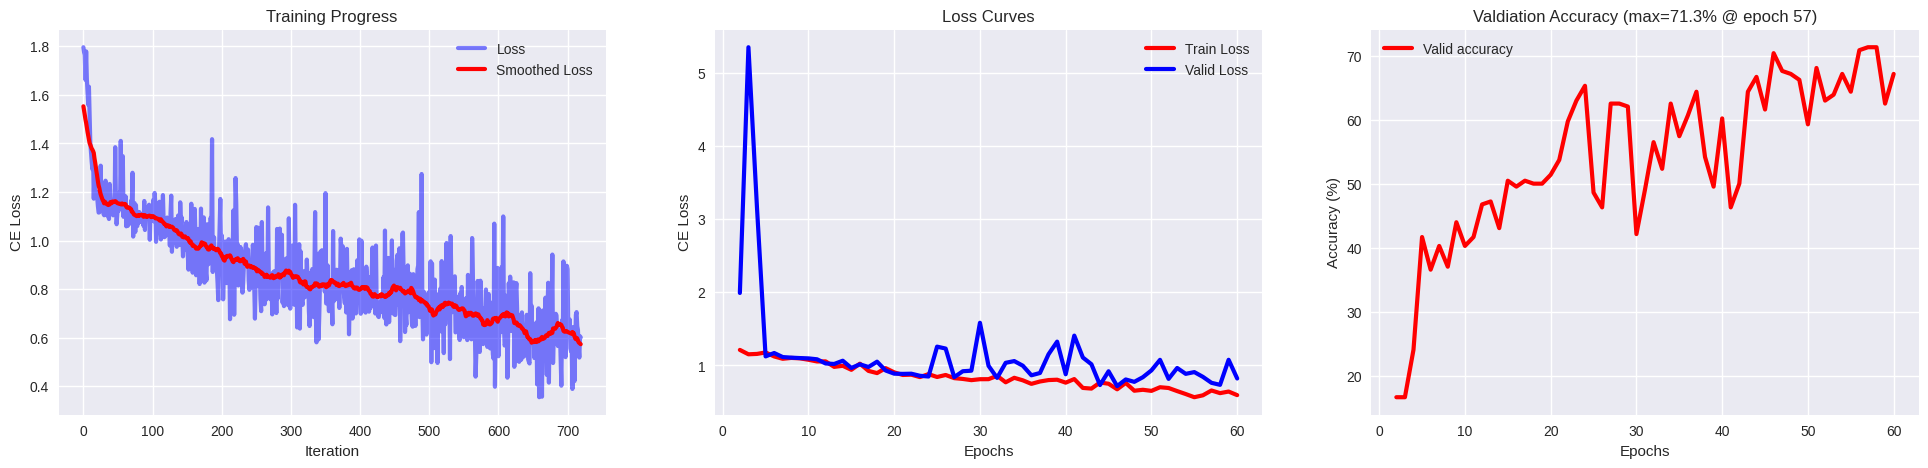

In [21]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[2].plot(epochs[1:], valid_acc[1:], c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

plt.show()